<a href="https://colab.research.google.com/github/KauanMoraes/Scientific-Computing/blob/main/Implementing_VGG16_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
%pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d balabaskar/wonders-of-the-world-image-classification
!unzip wonders-of-the-world-image-classification.zip

Dataset URL: https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification
License(s): CC0-1.0
100% 430M/432M [00:11<00:00, 43.6MB/s]
100% 432M/432M [00:11<00:00, 38.3MB/s]
Archive:  wonders-of-the-world-image-classification.zip
  inflating: Wonders of World/Wonders of World/burj_khalifa/0005487c0b.jpg  
  inflating: Wonders of World/Wonders of World/burj_khalifa/00d4a42317.jpg  
  inflating: Wonders of World/Wonders of World/burj_khalifa/01bbf1f63c.jpg  
  inflating: Wonders of World/Wonders of World/burj_khalifa/01f75e9545.jpg  
  inflating: Wonders of World/Wonders of World/burj_khalifa/020f2c752c.jpg  
  inflating: Wonders of World/Wonders of World/burj_khalifa/0305f7ae7d.jpg  
  inflating: Wonders of World/Wonders of World/burj_khalifa/04d516ea7d.jpg  
  inflating: Wonders of World/Wonders of World/burj_khalifa/04ecd64815.jpg  
  inflating: Wonders of World/Wonders of World/burj_khalifa/05168ad704.jpg  
  inflating: Wonders of World/Wonders of World/burj_kha

In [ ]:
import os

class CatsDogs(Dataset):
    def __init__(self, folder,size=500):

        self.classes = sorted(os.listdir(folder))  # Get all subfolders (classes)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}  # Create a mapping from class name to index
        self.targets = []
        self.fpaths=[]
        for cls_name in self.classes:  # Iterate through each class
            cls_fpaths = glob(os.path.join(folder, cls_name, '*.jpg'))  # Get all image paths for the class
            self.fpaths.extend(cls_fpaths[:size])  # Add image paths to the list (limit to "size" per class)
            self.targets.extend([self.class_to_idx[cls_name]] * len(cls_fpaths[:size]))  # Add corresponding labels

        self.normalize = transforms.Normalize(mean=[0.485,
                 0.456, 0.406],std=[0.229, 0.224,  0.225])
        from random import shuffle, seed; seed(10);
        shuffle(self.fpaths)


    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return (
            im.float().to(device),
            torch.tensor([target]).float().to(device)
        )

In [ ]:
from sklearn.model_selection import train_test_split
data = CatsDogs('Wonders of World/Wonders of World')

ind_treino, ind_teste = train_test_split(range(len(data)), test_size=0.25, random_state=42) #um possível problema eh que não preservamos a proporção

dados_treino = torch.utils.data.Subset(data, ind_treino)
dados_teste = torch.utils.data.Subset(data, ind_teste)

carregador_treino = DataLoader(dados_treino, batch_size=32, shuffle=True)
carregador_teste = DataLoader(dados_teste, batch_size=32, shuffle=True)


In [ ]:
len(dados_treino), len(dados_teste), len(data)


(2884, 962, 3846)

tensor([8.])


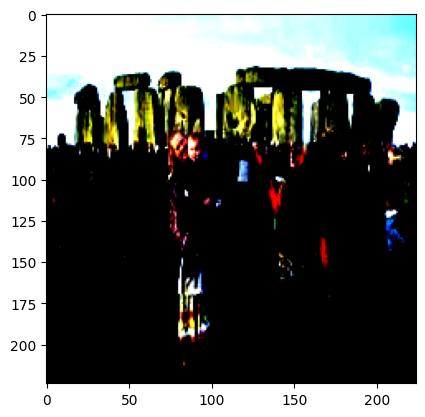

In [ ]:
im, label = data[3058]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
def get_model(num_classes):  # Pass the number of classes as an argument
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, num_classes),  # Output layer with num_classes units
                                     nn.Softmax(dim=1))  # Use Softmax for multi-class classification
    loss_fn = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

In [ ]:
%pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model(12)
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction,y.squeeze().long())
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction.argmax(dim=1) == y.squeeze().long()).cpu().numpy().tolist()
    return is_correct

In [ ]:
def get_data():
    train = dados_treino
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = dados_teste
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(12)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/5


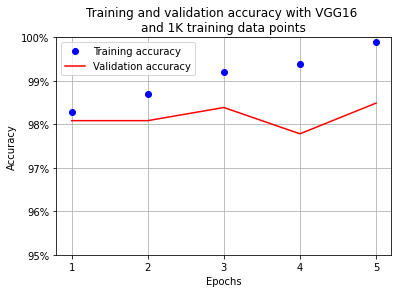

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()